# Классификация текстов: спам-фильтр для SMS

В настоящем проекте мы взяли открытый датасет с SMS-сообщениями, размеченными на спам ("spam") и не спам ("ham"), построили на нем классификатор текстов на эти два класса, оценили его качество посредством F1-меры, и посмотрели, что будет происходить с качеством, если менять параметры модели.

1. Загружаем датасет. Описание датасета можно посмотреть здесь: https://www.kaggle.com/uciml/sms-spam-collection-dataset.

2. Считываем датасет в Python, выясняя, что используется в качестве разделителей и как проставляются метки классов. Смотрим, как выглядят типичные сообщения обоих классов.

In [3]:
import re

file = open('SMSSpamCollection.txt', "r", encoding="utf-8").read()

print(re.search('ham\t(.+)\n', file).group(0))
print(re.search('spam\t(.+)\n', file).group(0))

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



3. Делим сообщения на 2 класса "спам" и "не спам", используя регулярные выражения. Создаем для дальнейшей работы список соответствующих меток классов. В качестве метки класса использовали 1 для спама и 0 для "не спама". Смотрим на (не)сбалансированность классов.
4. Разделяем датасет на обучающую и тестовую выборки в пропорции 80/20.

In [13]:
from sklearn.model_selection import train_test_split

ham = re.findall('ham\t(.+)\n', file)
spam = re.findall('spam\t(.+)\n', file)

print('Размер выборки:', len(ham+spam))
print('Количество не спама:', len(ham))
print('Количество спама:', len(spam))

data = ham + spam
labels = [0]*len(ham) + [1]*len(spam)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

Размер выборки: 5573
Количество не спама: 4826
Количество спама: 747


5. Используя CountVectorizer со стандартными настройками, получаем из текстов матрицу признаков X.
6. Классифицируем тексты с помощью LogisticRegression с параметрами по умолчанию, делаем предсказания и оцениваем их качество с помощью F1-меры.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

vectorizer = CountVectorizer()
logreg = LogisticRegression(solver='lbfgs')

clf_pipeline = Pipeline(
            [("vectorizer", vectorizer), ("classifier", logreg)])
clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
print(f1_score(y_test, y_pred))

0.962962962962963


7. Повторяем шаги из п.4 и п.5 для TfidfVectorizer. И замечаем, что качество ухудшается. Учитывая, что тексты не были предобаботаны (удаление знаков препинания и лемматизация слов), могла получиться довольна разреженная матрица признаков.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

clf_pipeline = Pipeline(
            [("vectorizer", vectorizer), ("classifier", logreg)])
clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
print(f1_score(y_test, y_pred))

0.8880866425992779


8. Задаем в CountVectorizer параметр ngram_range=(2,2), затем ngram_range=(3,3), затем ngram_range=(1,3). Во всех трех случаях измеряем получившееся значение F1-меры. В данном эксперименте мы пробуем добавлять в признаки n-граммы для разных диапазонов n - только биграммы, только триграммы, и, наконец, все вместе - униграммы, биграммы и триграммы. Обратим внимание, что статистики по биграммам и триграммам намного меньше, поэтому классификатор только на них работает хуже. В то же время это не ухудшает результат сколько-нибудь существенно, если добавлять их вместе с униграммами, т.к. за счет регуляризации линейный классификатор не склонен сильно переобучаться на этих признаках.

In [16]:
for var in [(2, 2), (3, 3), (1, 3)]:
    vectorizer = CountVectorizer(ngram_range=var)
    
    clf_pipeline = Pipeline(
            [("vectorizer", vectorizer), ("classifier", logreg)])
    clf_pipeline.fit(X_train, y_train)
    
    y_pred = clf_pipeline.predict(X_test)
    print(var, f1_score(y_test, y_pred))

(2, 2) 0.7530364372469636
(3, 3) 0.6949152542372882
(1, 3) 0.9488054607508533


In [17]:
test = input('Ваше тестовое сообщение: ')

vectorizer = TfidfVectorizer()

clf_pipeline = Pipeline(
            [("vectorizer", vectorizer), ("classifier", logreg)])
clf_pipeline.fit(X_train, y_train)

pred = ['ham' if x==0 else 'spam' for x in clf_pipeline.predict([test])]

print(*pred)

Ваше тестовое сообщение:  Have you visited the last lecture on physics?


ham


# Матрица ошибок

In [1]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Матрица ошибок (матрица неточностей) — это таблица, которая позволяет визуализировать эффективность алгоритма классификации путем сравнения прогнозируемого значения целевой переменной с ее фактическим значением.

1. Создаём матрицу ошибок с помощью confusion_matrix из модуля _sklearn.metrics_;
2. Задаём размер матрицы 8x6;
3. Задаём точность отображения процентов до 2 знаков после запятой;
4. С помощью модуля _seaborn_ выводим матрицу;
5. Выводим точность модели.

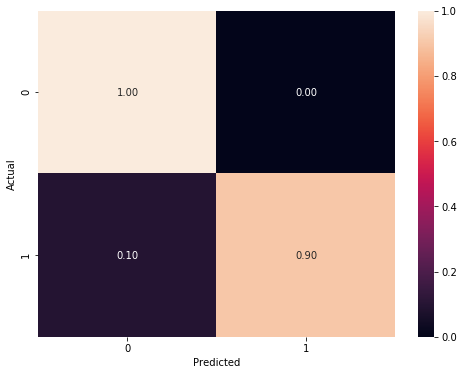

Model Accuracy: 0.9862548165560714


In [21]:
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
print(f'Model Accuracy: {f1_score(y_test, y_pred, average="weighted")}')

# Сводка о классификации

In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_test, y_pred, target_names=['spam', 'ham']))

              precision    recall  f1-score   support

        spam       0.98      1.00      0.99       961
         ham       1.00      0.90      0.95       154

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



С помощью _classification report_ из модуля _sklearn.metrics_ выводим отчёт о точности классификации с рассчитаным F1-Score.

# Вывод

Наивысшее качество (94,67%) в нашей задачи классификация показывает CountVectorizer с использованием сочетания только униграмм в качестве признаков.

# Бонус

Примеры сообщений для теста:

"FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GB";

"FreeMsg: Txt: claim your reward of 3 hours talk time";

"Have you visited the last lecture on physics?";

"Have you visited the last lecture on physics? Just buy this book and you will have all materials! Only 99$";

"Only 99$".